In [1]:
# import libraries 
library(ggplot2)
library(tidyverse)
library(ggfortify)
library(ggrepel)
library(factoextra)
library(FactoMineR)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.1     v stringr   1.5.2
v lubridate 1.9.4     v tibble    3.3.0
v purrr     1.1.0     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
sharks = read.table("datasets/shark_immunity.txt", header = TRUE, sep = "\t")

# change the order the physiological conditions are displayed 
sharks$physiological_condition <- factor(
  sharks$physiological_condition,
  levels = c("Healthy", "Stressed", "Injured", "Infected", "Recovering")
)
# reduces name to just the gene
names(sharks) <- sub("_expression", "", names(sharks))

# dataframe with gene expression split into 2 variables
sharks_genes = sharks %>% 
    pivot_longer(
        cols = starts_with("Gene_"),
        names_to = "gene",
        values_to = "expression"
    )

# dataframe where all numerical variables are split into 2 variables
sharks_super_long <- sharks %>%
  select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F, regeneration_capacity, age_years, immune_receptor_diversity, response_to_infection, weight_kg, inflammation_level, resilience_score, reproduction_rate) %>% 
  pivot_longer(cols = -c("physiological_condition","immune_cell_type","Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F"), names_to = "variable", values_to = "value") %>%
    select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F,variable,value) %>% 
    pivot_longer(cols = -c("physiological_condition", "immune_cell_type","variable","value"), names_to = "gene", values_to = "expression")

In [3]:
# data selection functions
condition_data = function(data, condition) {
    data[data$physiological_condition==condition, ]
}

cell_data = function(data, cell_type) {
    data[data$immune_cell_type==cell_type, ]
}

(PCA on gene expressions)

strongest > weakest

DC > NK > TC > Macro > BC > Mono

things to investigate? 
- D ~ F (injured)
- C ~ D, A ~ B ~ E (infected)
- A ~ B (recovering)
- A,B,D ~ DC (recovering)
- increased (but larger range) gene expression for DC, reduced gene expression for NK (recovering)
- overall increased gene expression for DC (stressed) (NK is more general)

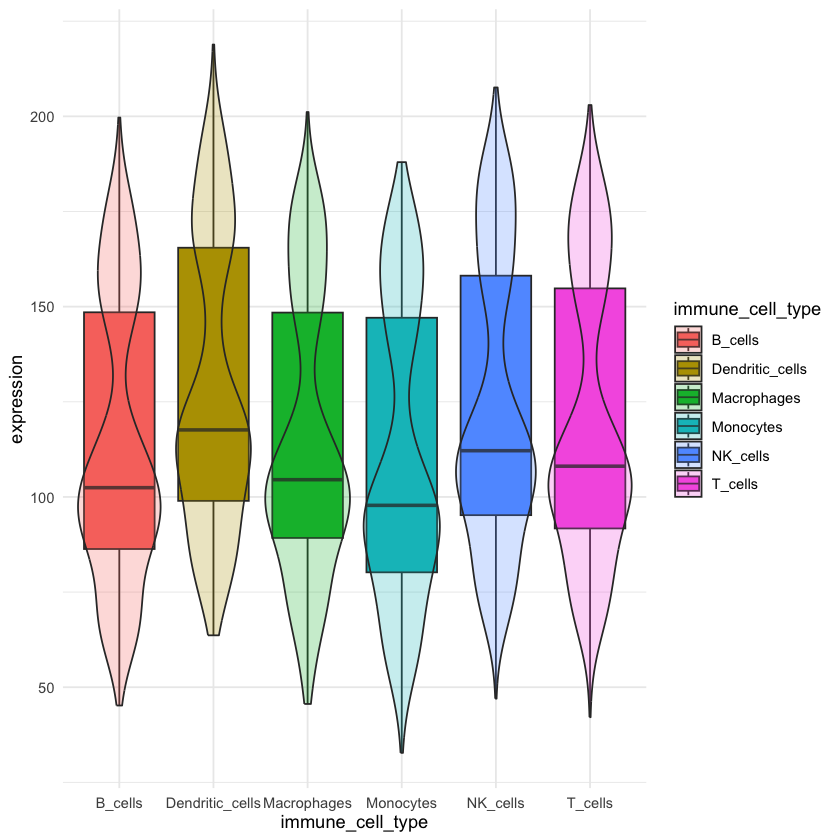

In [138]:
# how do gene expression levels vary across immune cell types?
ggplot(sharks_genes, aes(x=immune_cell_type, y=expression, fill=immune_cell_type)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal()

(?) statistical test to check if the average is significantly higher

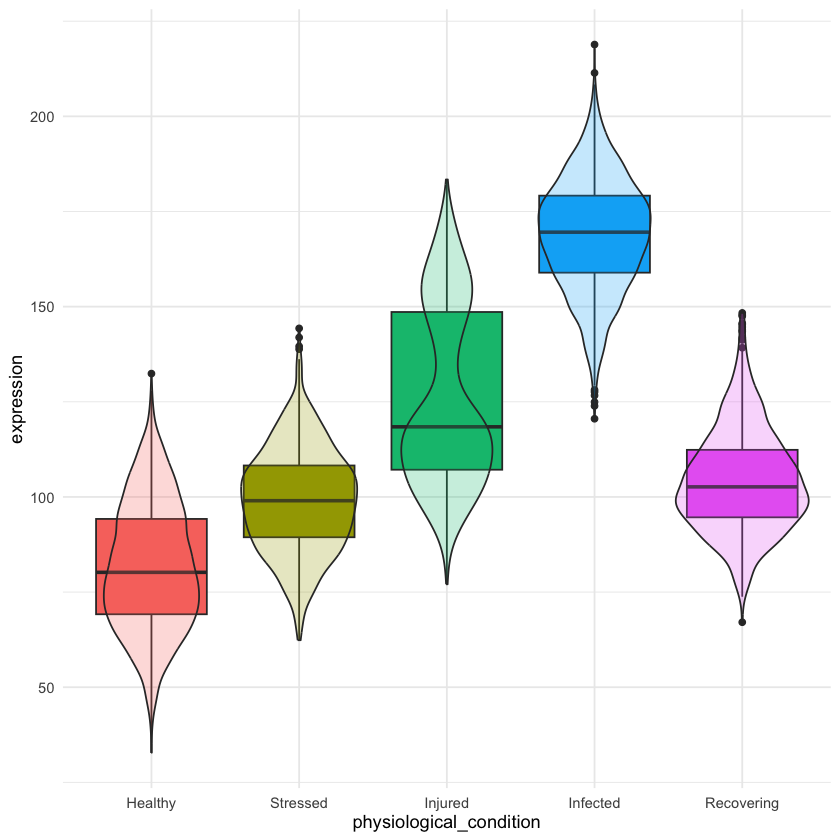

In [142]:
# how do gene expression levels vary across physiological conditions
ggplot(sharks_genes, aes(x=physiological_condition, y=expression, fill=physiological_condition)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(legend.position="None")

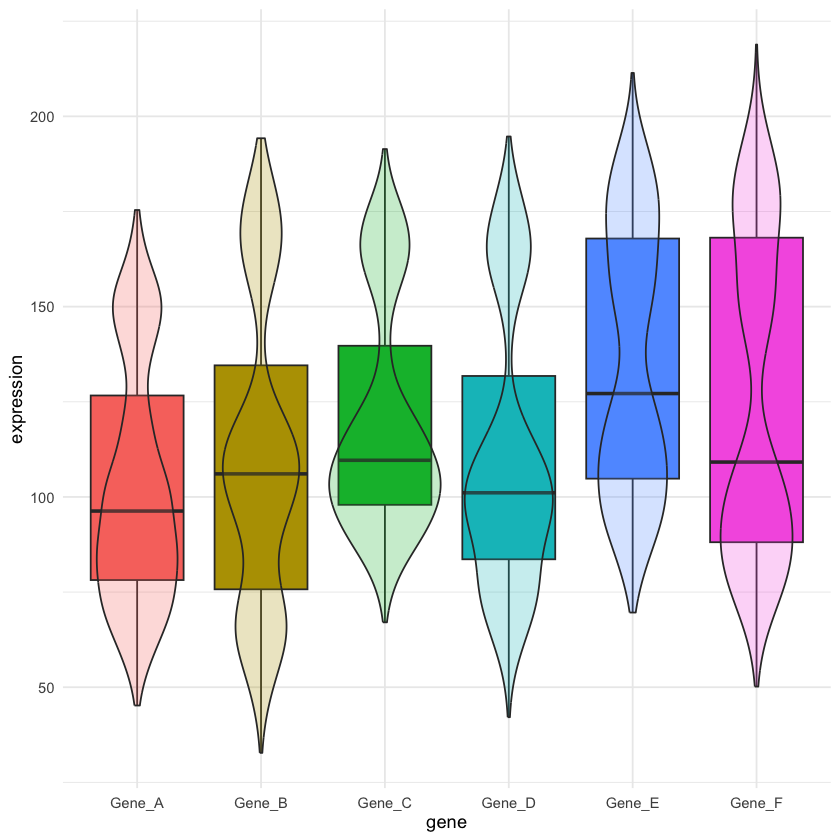

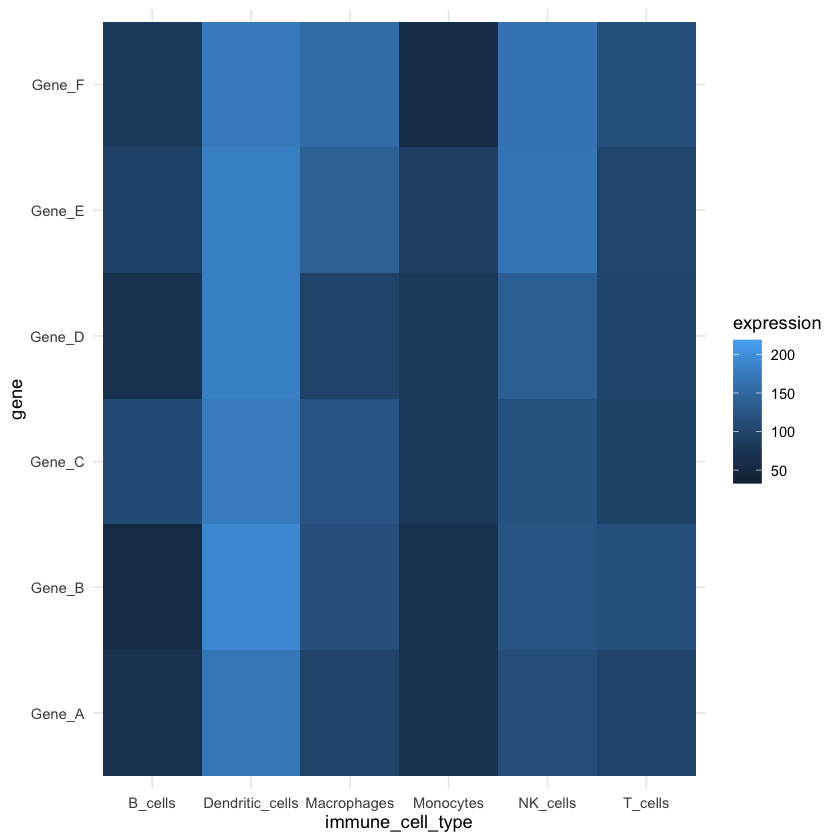

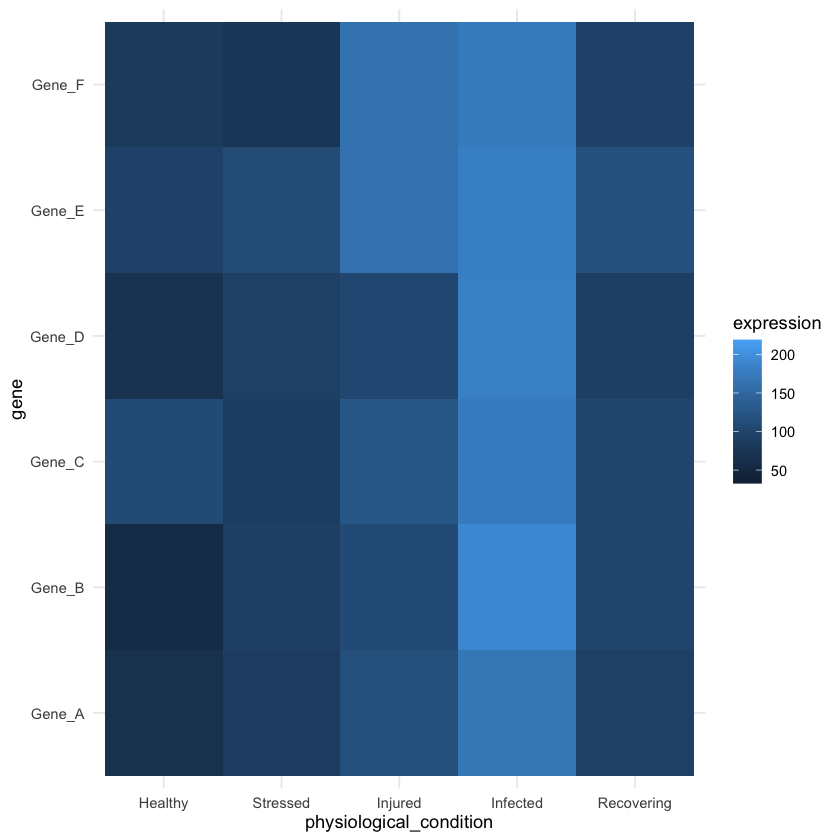

In [143]:
# are the expression levels different for each gene?
ggplot(sharks_genes, aes(x=gene, y=expression, fill=gene)) +
    geom_boxplot() +
    geom_violin(alpha=0.25) +
    theme_minimal() +
    theme(legend.position="None")

ggplot(sharks_genes, aes(x=immune_cell_type, y=gene, fill=expression)) +
    geom_tile() +
    theme_minimal()

ggplot(sharks_genes, aes(x=physiological_condition, y=gene, fill=expression)) +
    geom_tile() +
    theme_minimal()

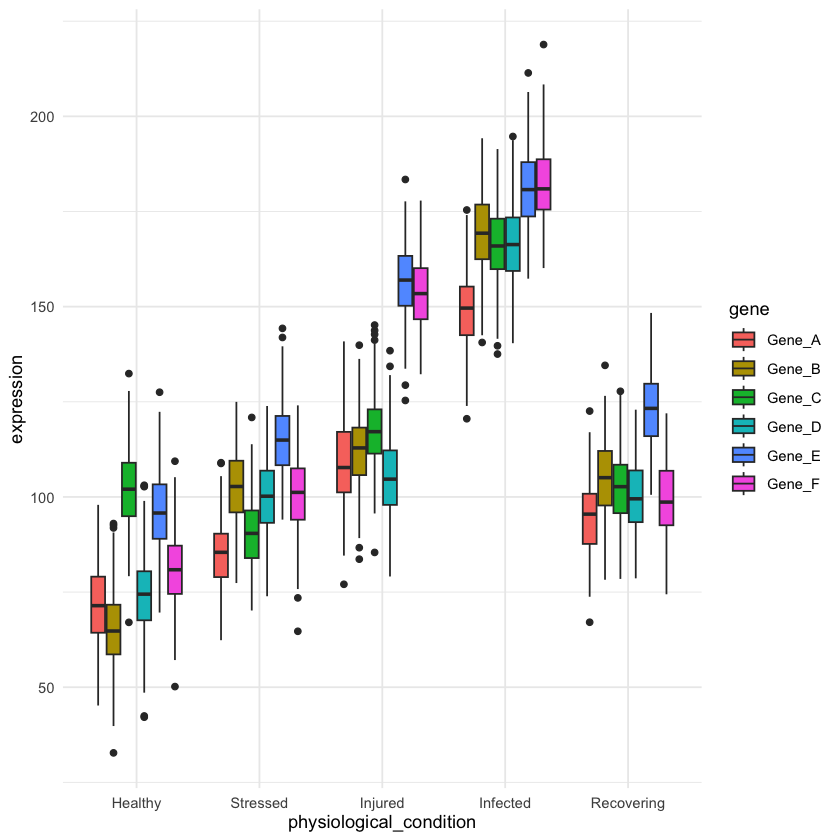

In [11]:
# do the expression levels for each gene vary according to the physiological condition? 
ggplot(sharks_genes, aes(x=physiological_condition, y=expression, fill=gene)) +
    geom_boxplot() +
    theme_minimal()

(?) injured : E,F // A,B,C,D --> what effect?
- E,F not correlated (cc); F~D

(?) recovering : E // A,B,C,D,F --> what effect?
- A,F correlated

(?) C : healthy > stressed --> what effect?
- E apart from others
- A ~ D (~ B)?, C ~ F?

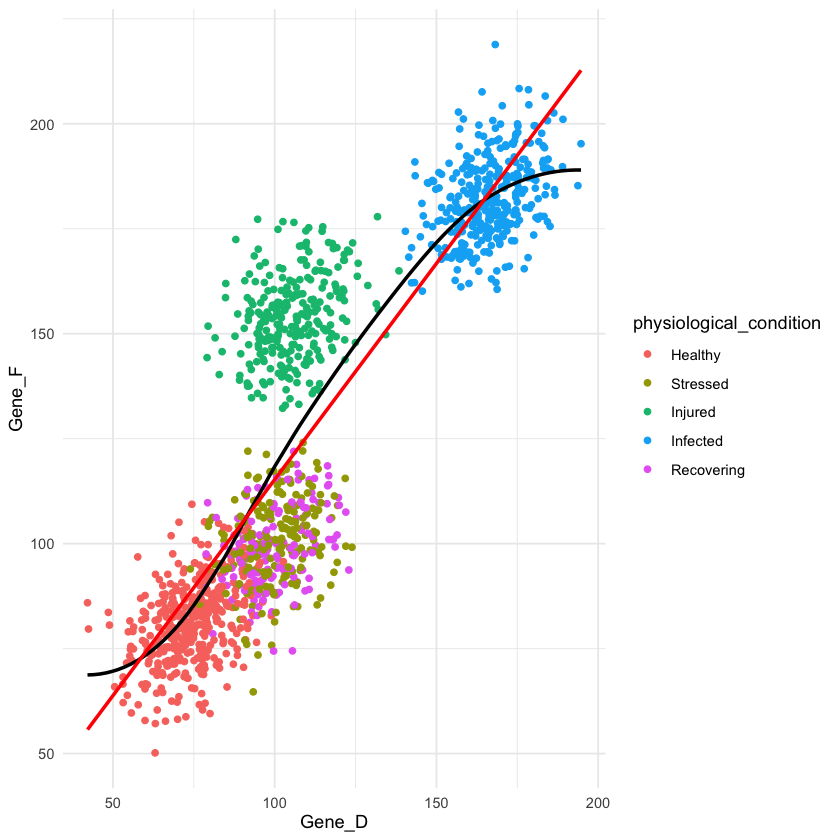

In [82]:
# is there a relationship between genes D and F?
ggplot(sharks, aes(x=Gene_D, y=Gene_F, col=physiological_condition)) +
    geom_point() +
    geom_smooth(method="loess", formula="y ~ x", col="black", se=FALSE) +
    geom_smooth(method="lm", formula="y ~ x", col="red", se=FALSE) +
    theme_minimal()

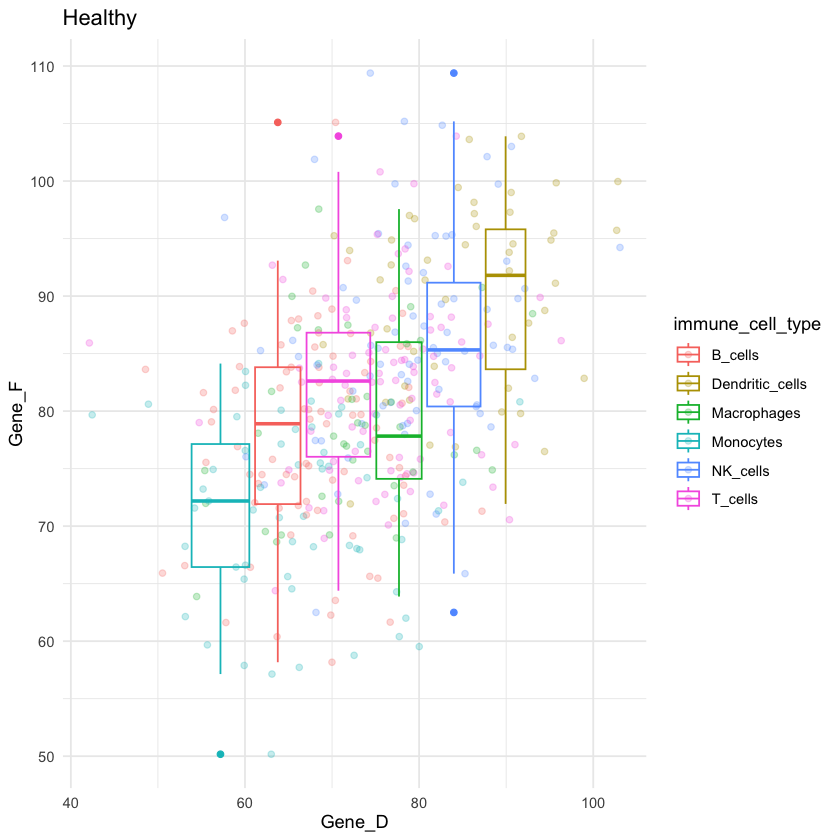

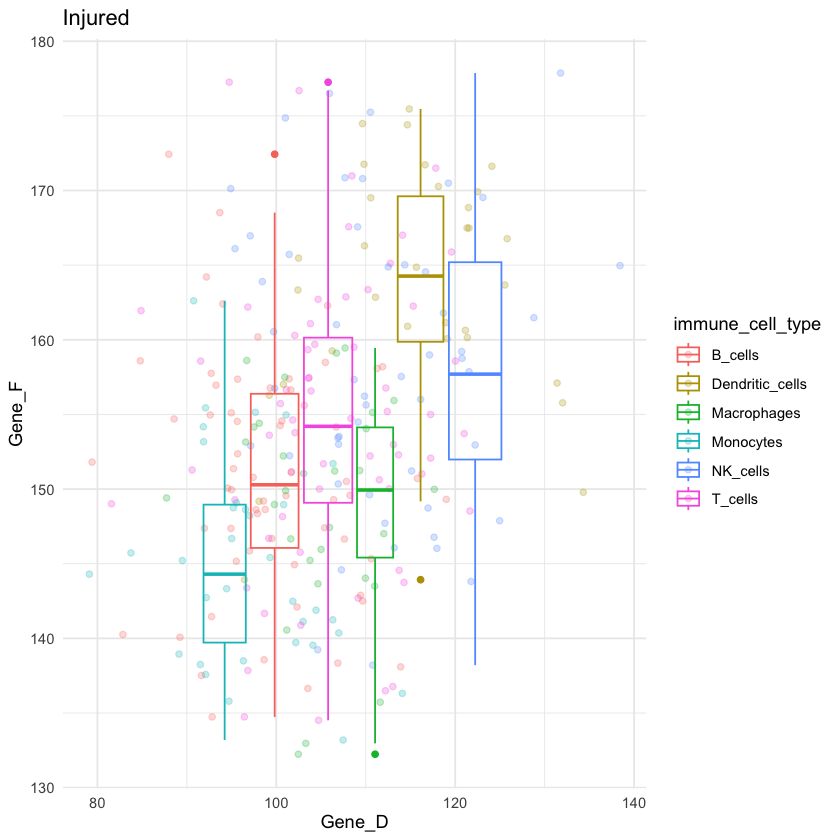

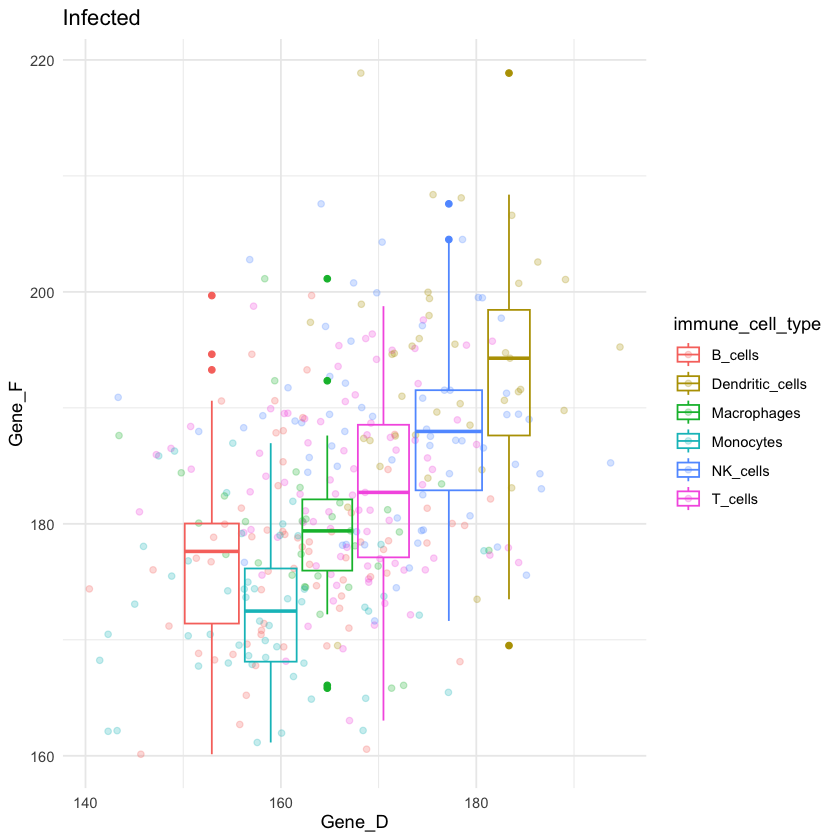

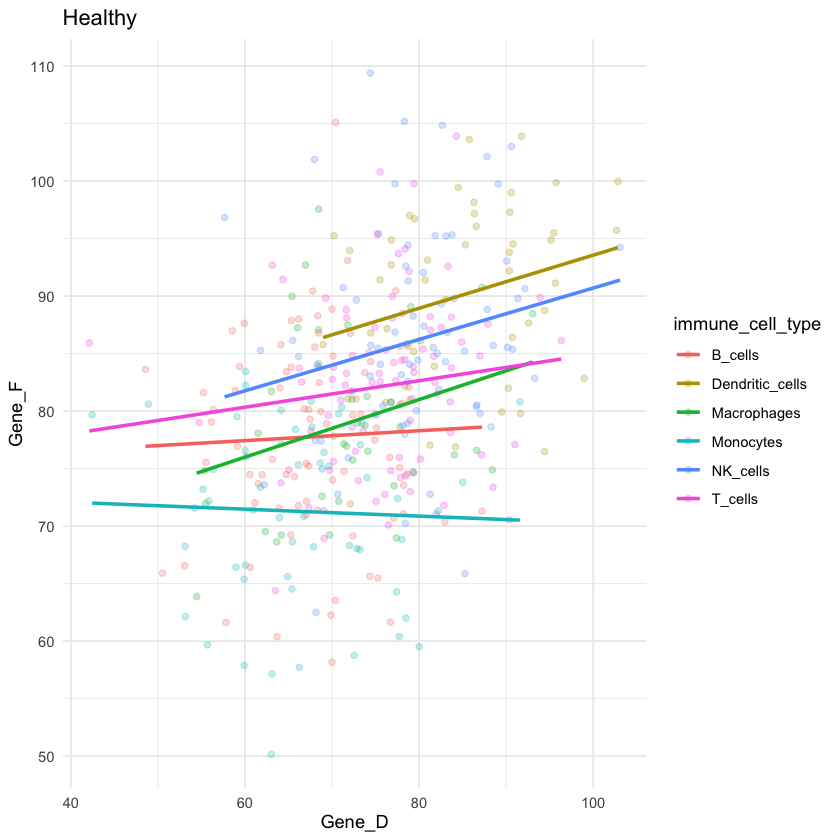

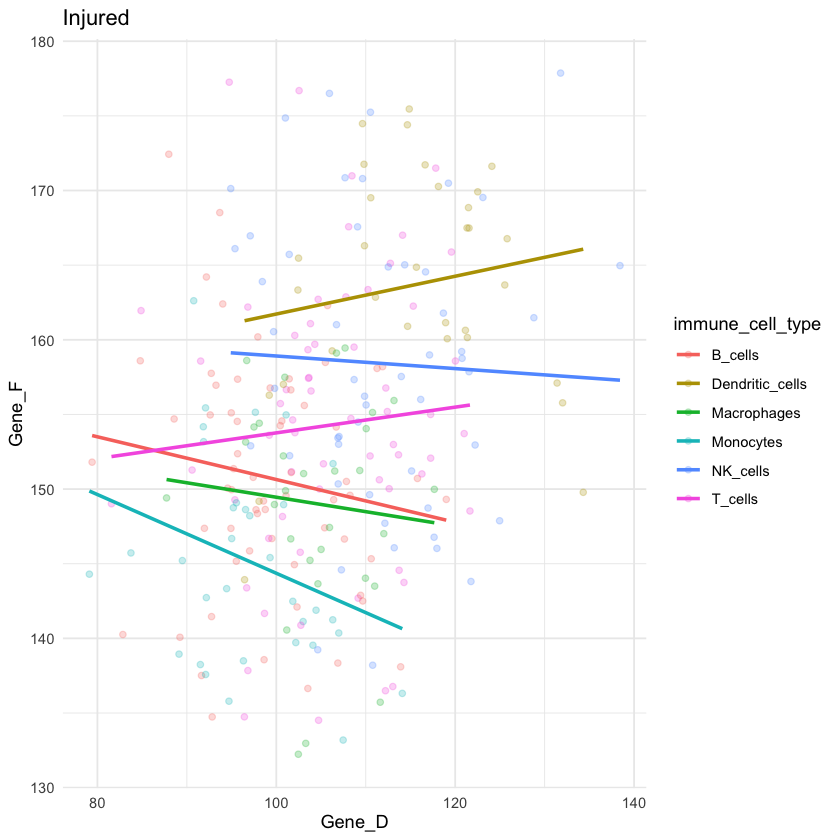

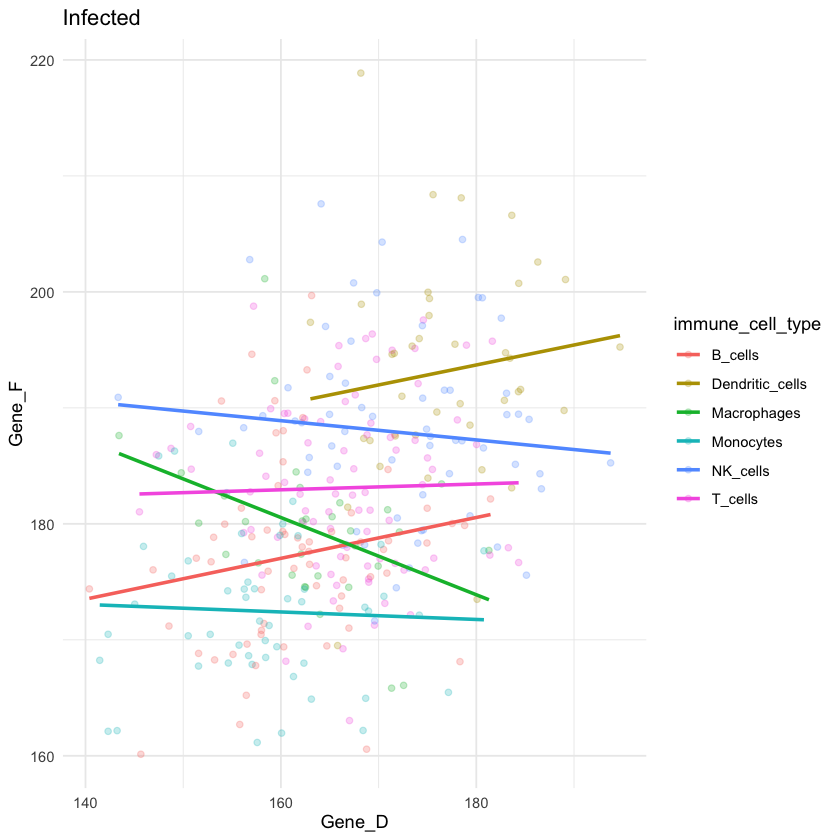

In [112]:
# does the D-F relationship change in different conditions (primarily healthy/injured/infected) and cell types ?
ggplot(condition_data(sharks,"Healthy"), aes(x=Gene_D, y=Gene_F, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(sharks,"Injured"), aes(x=Gene_D, y=Gene_F, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Injured")

ggplot(condition_data(sharks,"Infected"), aes(x=Gene_D, y=Gene_F, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Infected")

ggplot(condition_data(sharks,"Healthy"), aes(x=Gene_D, y=Gene_F, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(sharks,"Injured"), aes(x=Gene_D, y=Gene_F, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Injured")

ggplot(condition_data(sharks,"Infected"), aes(x=Gene_D, y=Gene_F, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Infected")

(?) higher contribution of gene expression by dendritic cells in injured condition = significant/not

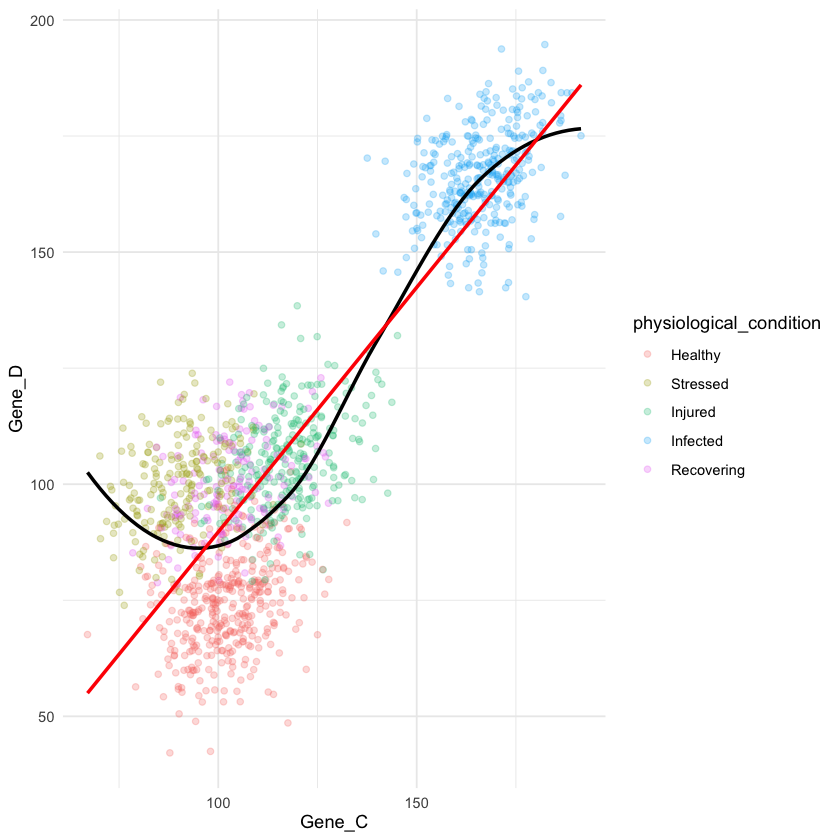

In [97]:
# is there a relationship between genes C and D?
ggplot(sharks, aes(x=Gene_C, y=Gene_D, col=physiological_condition)) +
    geom_point(alpha=0.25) +
    geom_smooth(method="loess", formula="y ~ x", col="black", se=FALSE) +
    geom_smooth(method="lm", formula="y ~ x", col="red", se=FALSE) +
    theme_minimal()

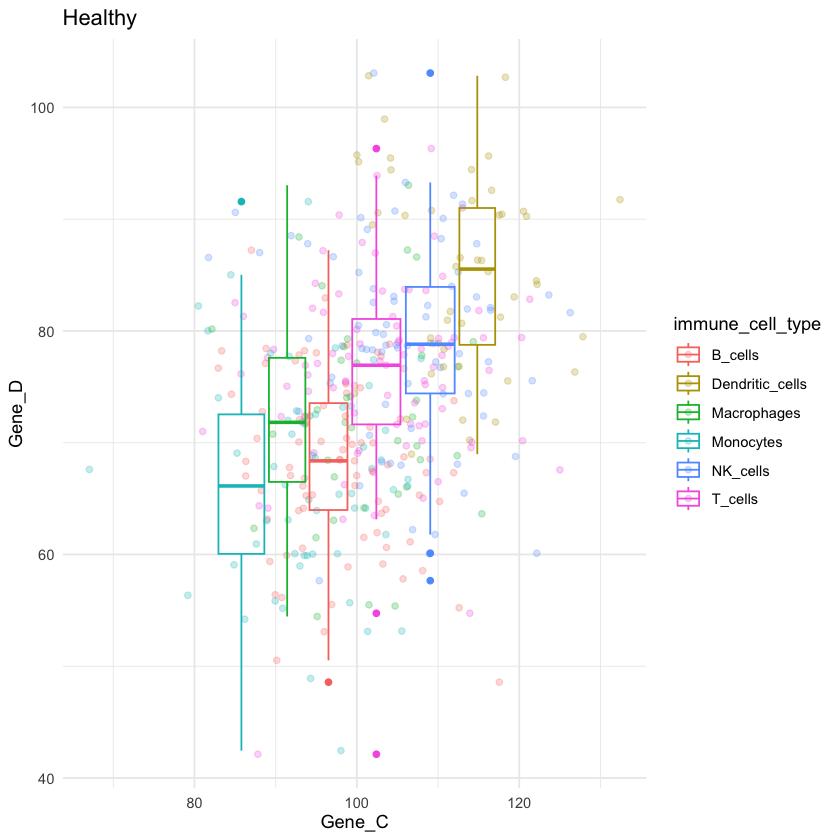

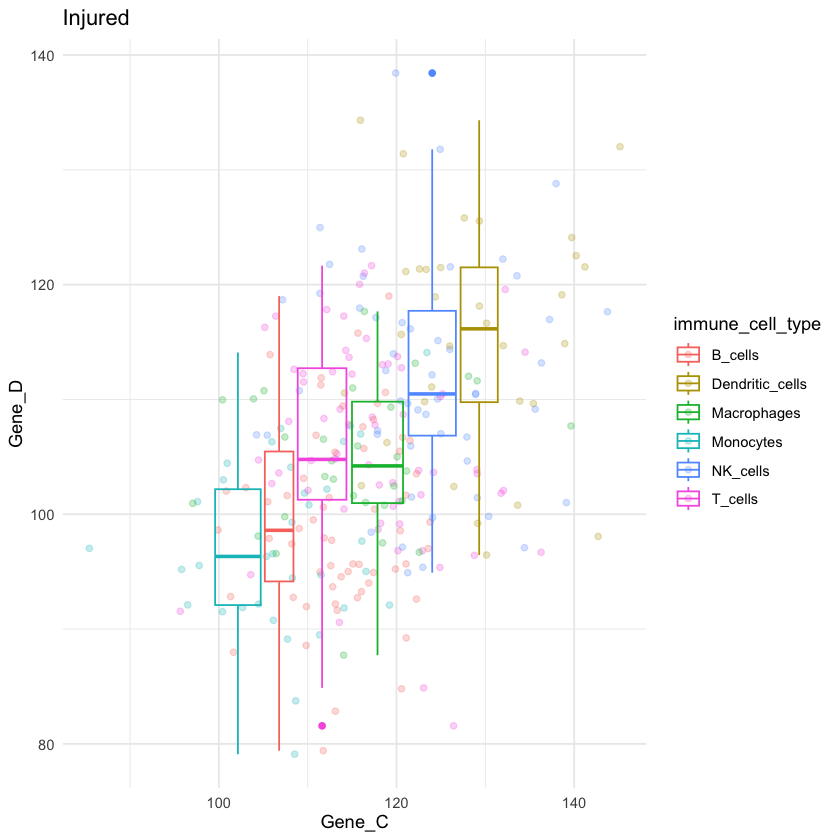

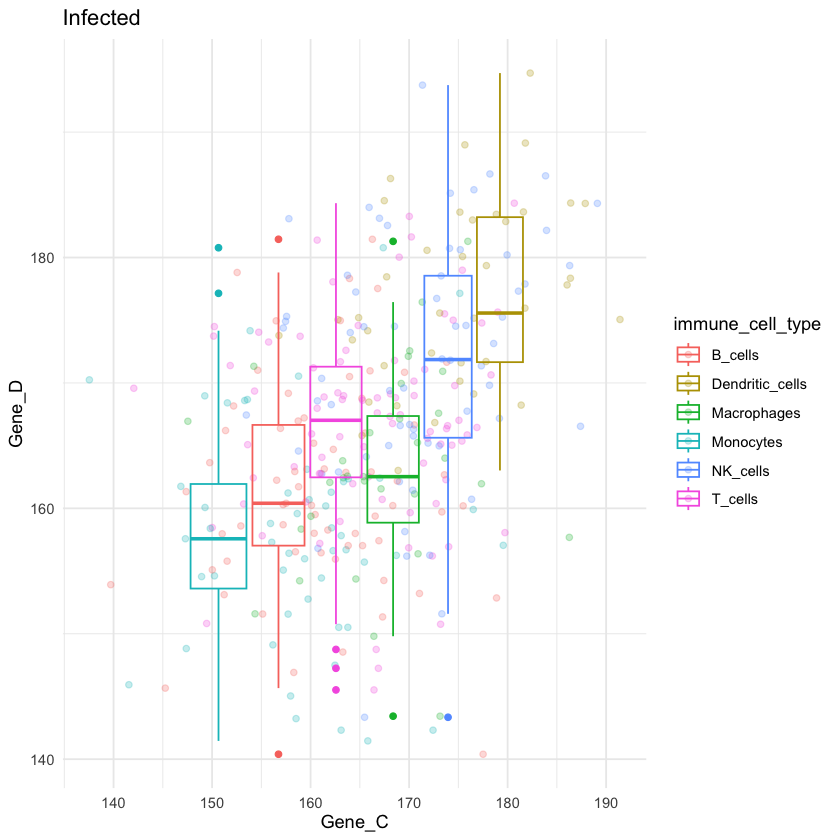

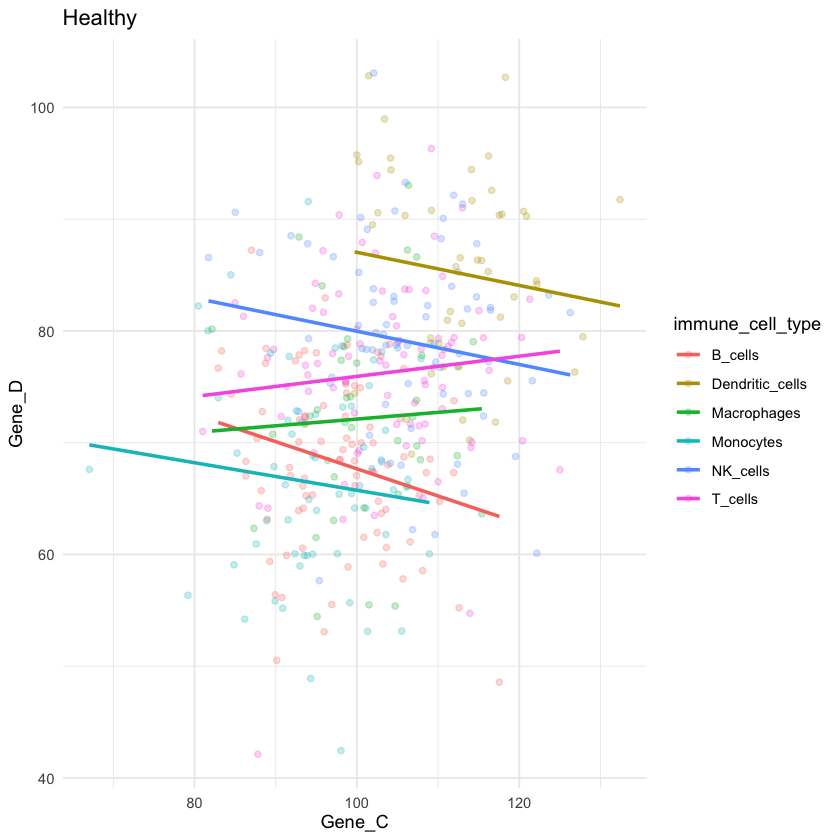

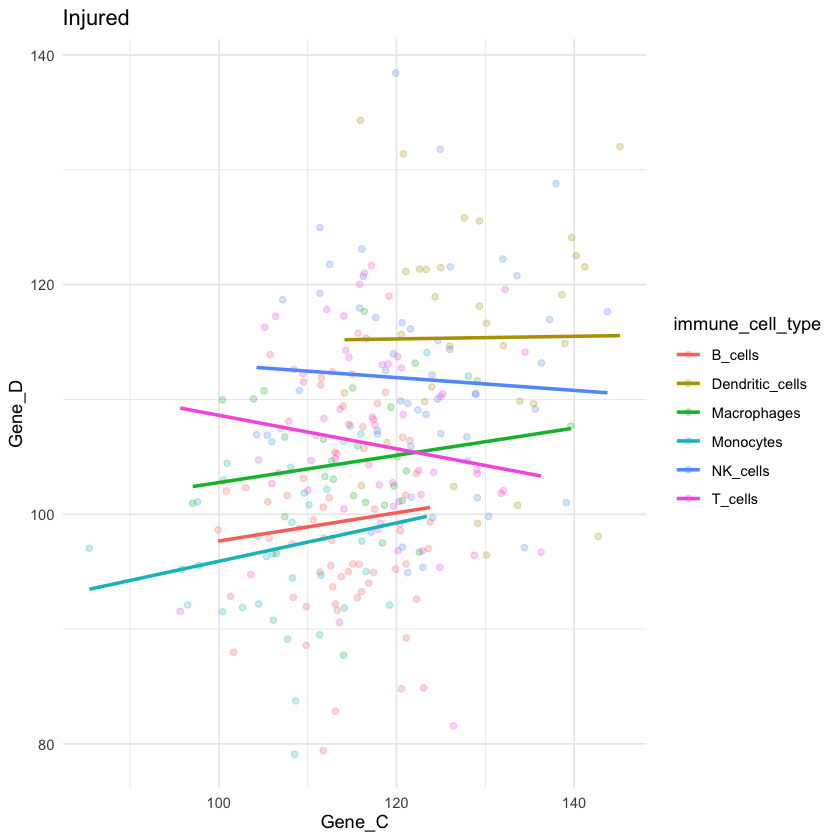

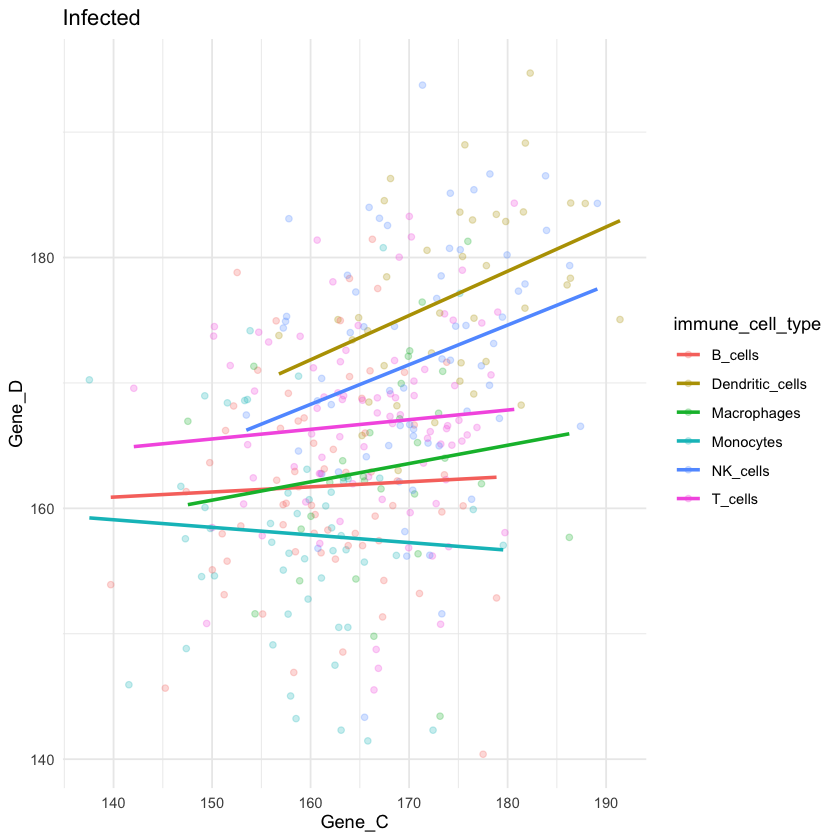

In [111]:
# does the C-D relationship change in different conditions (primarily healthy/injured/infected) and cell types?
ggplot(condition_data(sharks,"Healthy"), aes(x=Gene_C, y=Gene_D, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(sharks,"Injured"), aes(x=Gene_C, y=Gene_D, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Injured")

ggplot(condition_data(sharks,"Infected"), aes(x=Gene_C, y=Gene_D, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Infected")

ggplot(condition_data(sharks,"Healthy"), aes(x=Gene_C, y=Gene_D, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(sharks,"Injured"), aes(x=Gene_C, y=Gene_D, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Injured")

ggplot(condition_data(sharks,"Infected"), aes(x=Gene_C, y=Gene_D, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Infected")

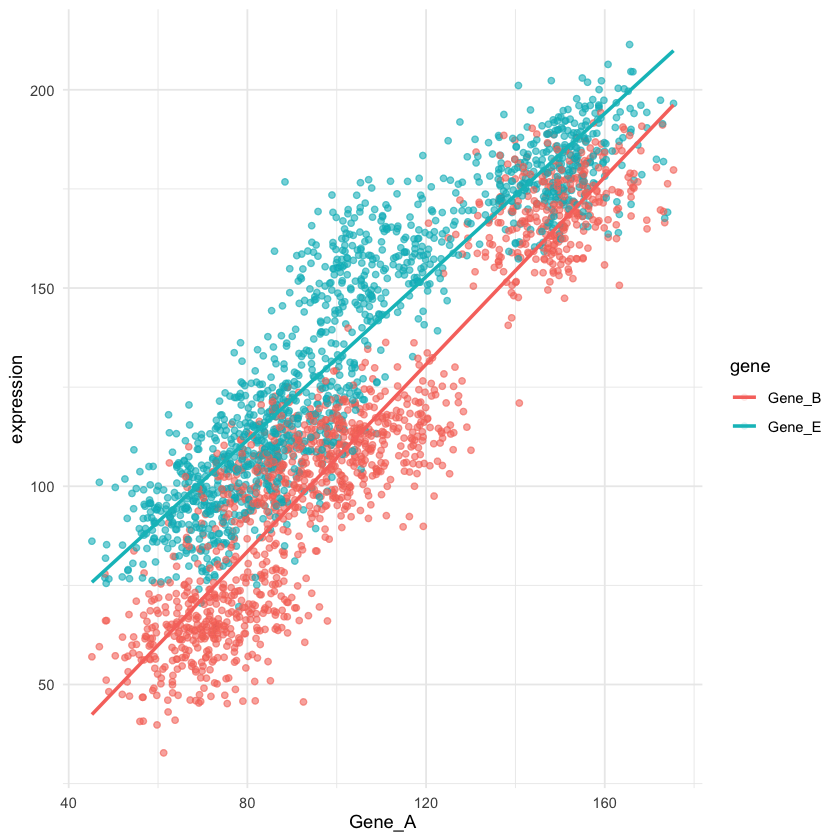

In [93]:
# is there a relationship between genes A, B, and E?
with_A <- sharks %>%
  select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F, regeneration_capacity, age_years, immune_receptor_diversity, response_to_infection, weight_kg, inflammation_level, resilience_score, reproduction_rate) %>% 
  pivot_longer(cols = -c("physiological_condition","immune_cell_type","Gene_A","Gene_B","Gene_C","Gene_D","Gene_E","Gene_F"), names_to = "variable", values_to = "value") %>%
    select(physiological_condition, immune_cell_type, Gene_A, Gene_B, Gene_C, Gene_D, Gene_E, Gene_F,variable,value) %>% 
    pivot_longer(cols = -c("physiological_condition", "immune_cell_type","variable","value", "Gene_A"), names_to = "gene", values_to = "expression")

genes_ABE = with_A %>%
    filter(gene %in% c("Gene_B","Gene_E"))

ggplot(genes_ABE, aes(x=Gene_A, y=expression, col=gene)) +
    geom_point(alpha=0.1) +
    geom_smooth(aes(group=gene, color=gene), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal()

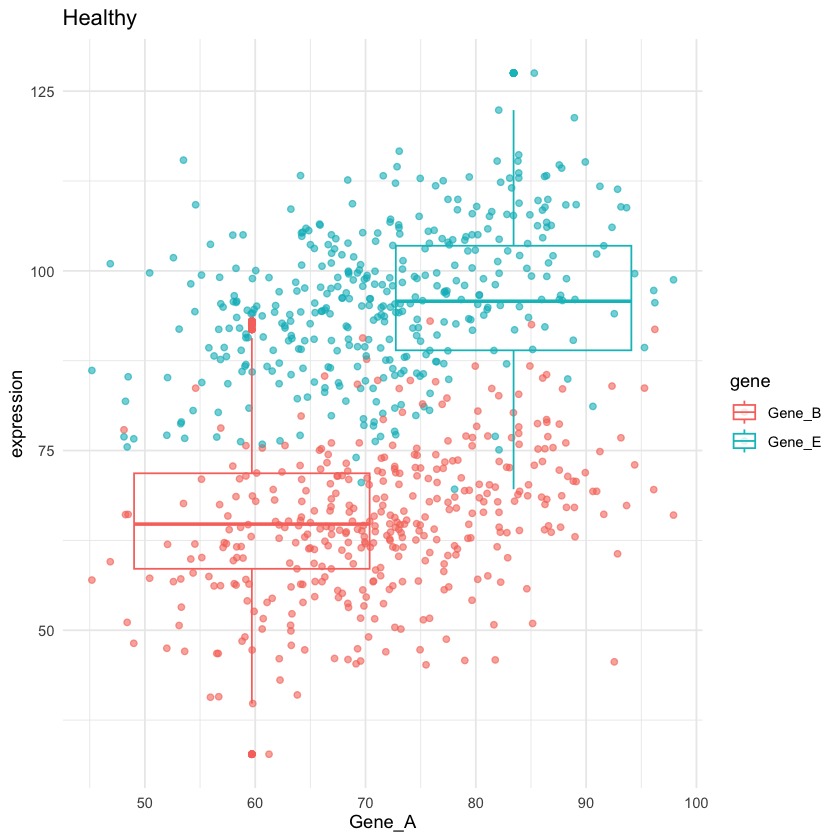

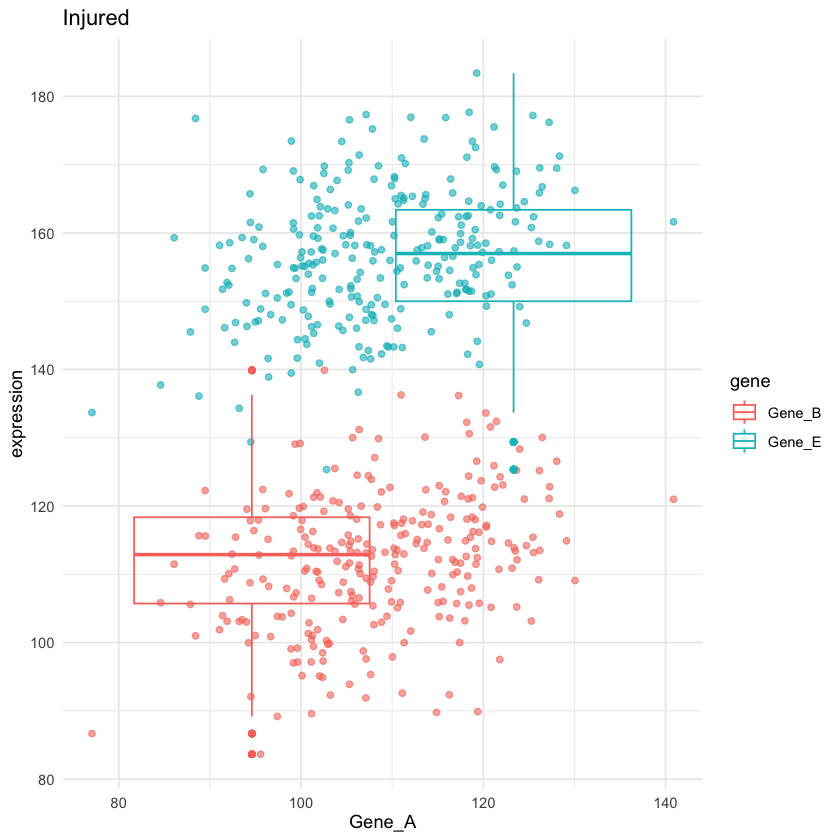

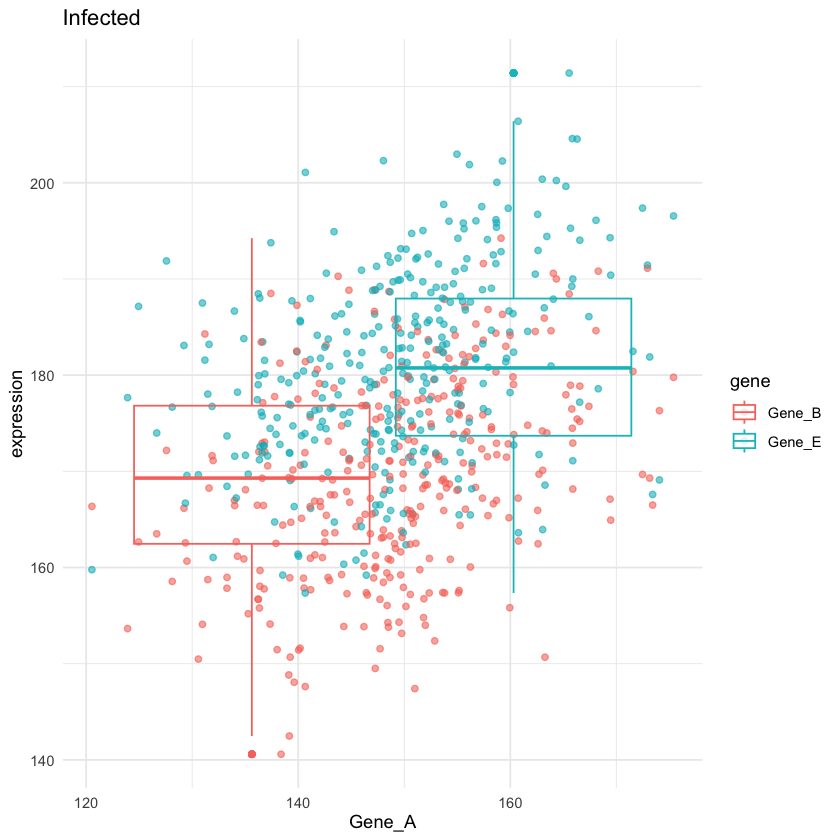

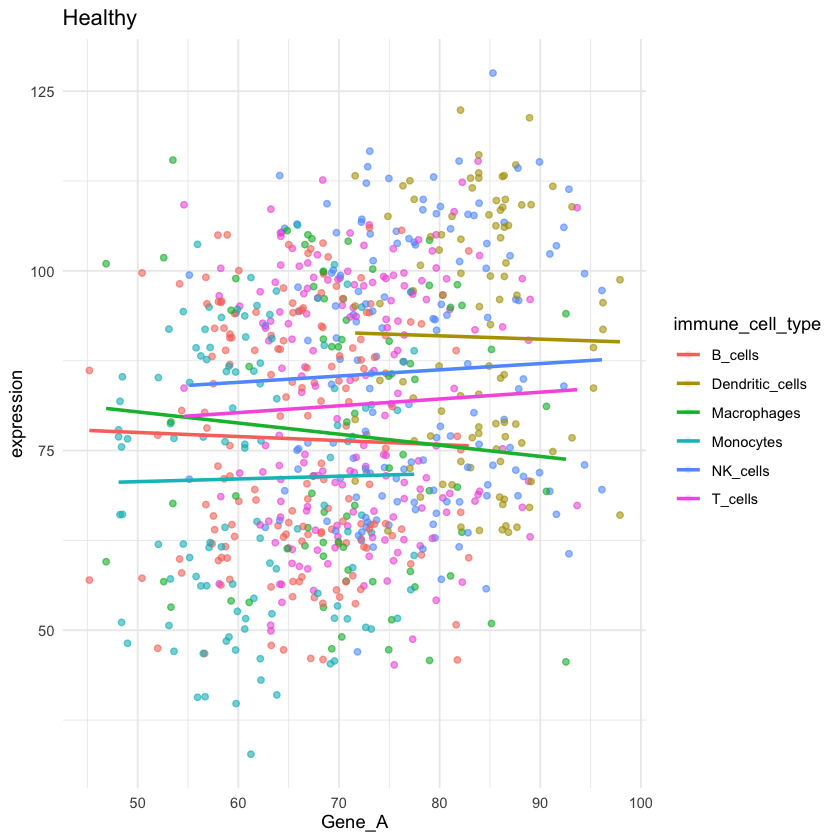

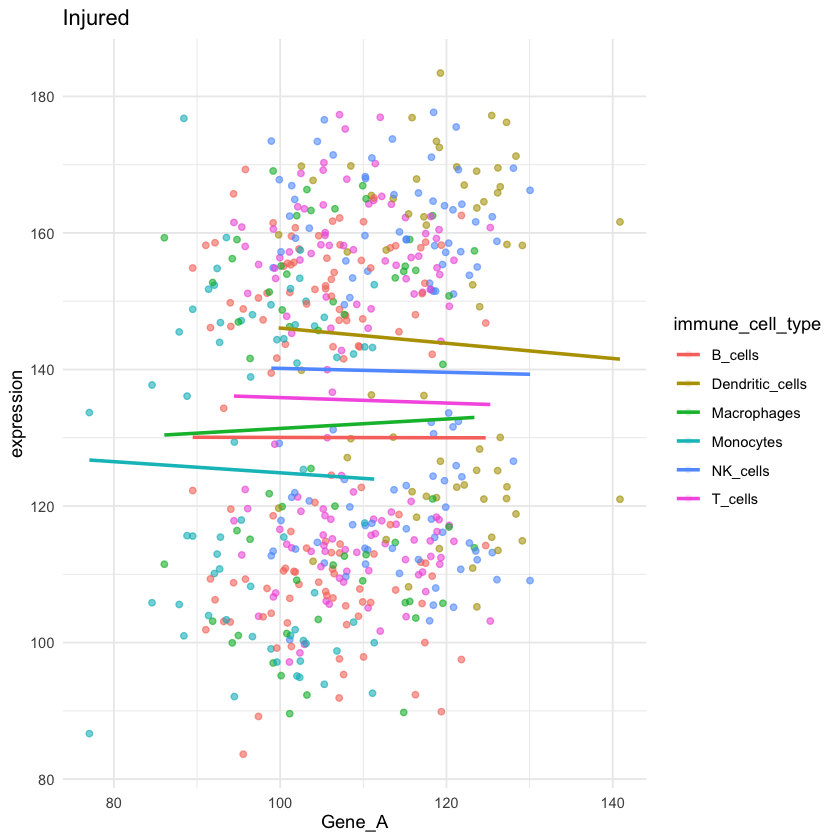

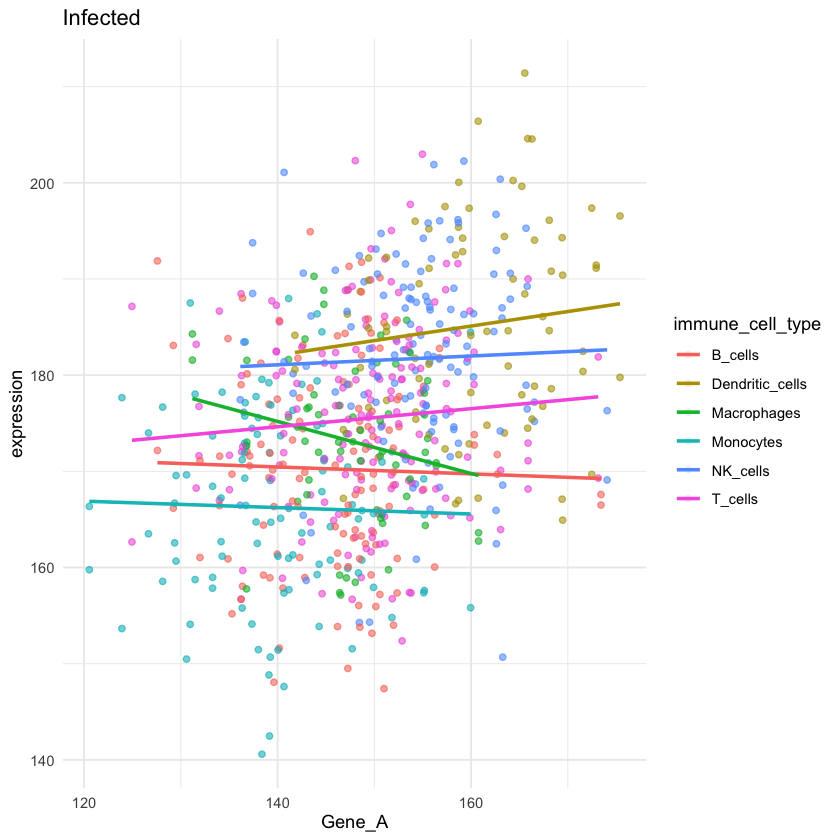

In [118]:
# does the A-B-E relationship change in different conditions (primarily healthy/injured/infected) ?
ggplot(condition_data(genes_ABE,"Healthy"), aes(x=Gene_A, y=expression, col=gene)) +
    geom_point(alpha=0.1) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(genes_ABE,"Injured"), aes(x=Gene_A, y=expression, col=gene)) +
    geom_point(alpha=0.1) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Injured")

ggplot(condition_data(genes_ABE,"Infected"), aes(x=Gene_A, y=expression, col=gene)) +
    geom_point(alpha=0.1) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Infected")

ggplot(condition_data(genes_ABE,"Healthy"), aes(x=Gene_A, y=expression, col=immune_cell_type)) +
    geom_point(alpha=0.1) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(genes_ABE,"Injured"), aes(x=Gene_A, y=expression, col=immune_cell_type)) +
    geom_point(alpha=0.1) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Injured")

ggplot(condition_data(genes_ABE,"Infected"), aes(x=Gene_A, y=expression, col=immune_cell_type)) +
    geom_point(alpha=0.1) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Infected")

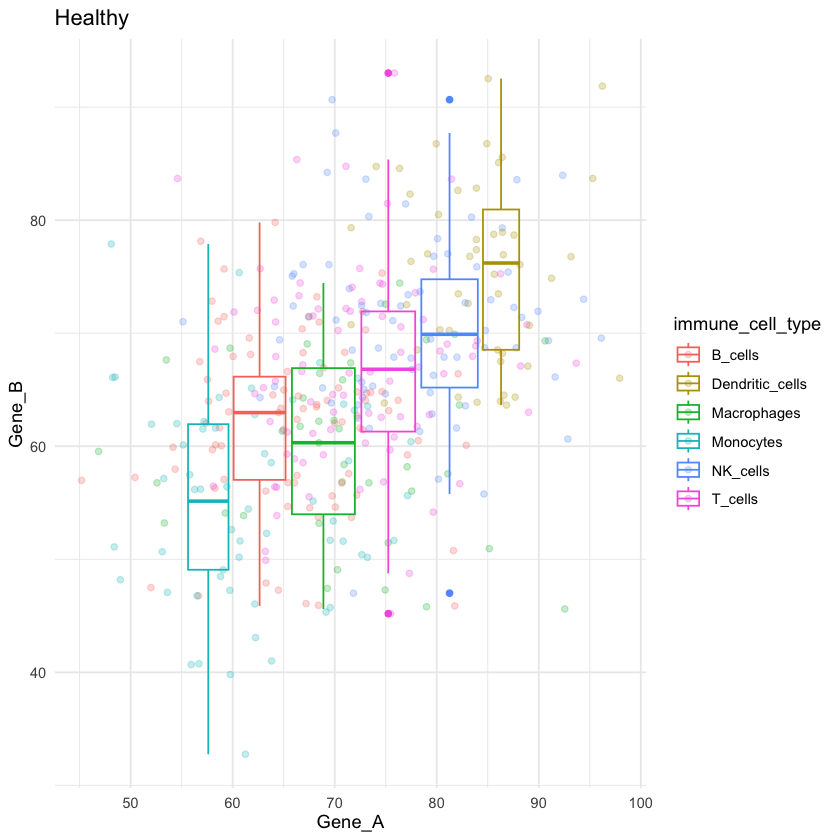

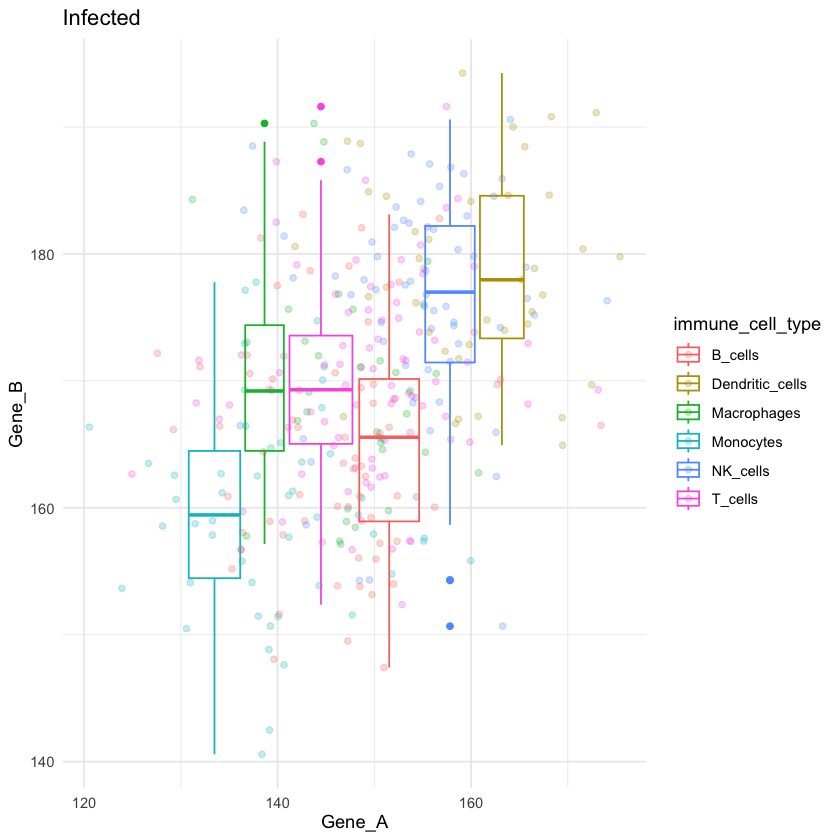

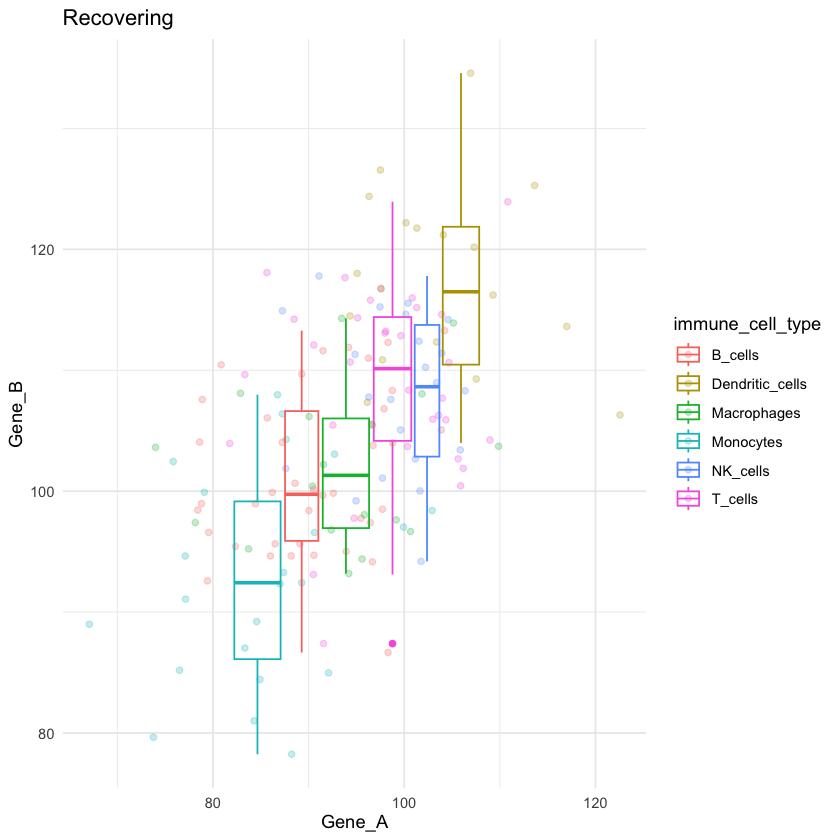

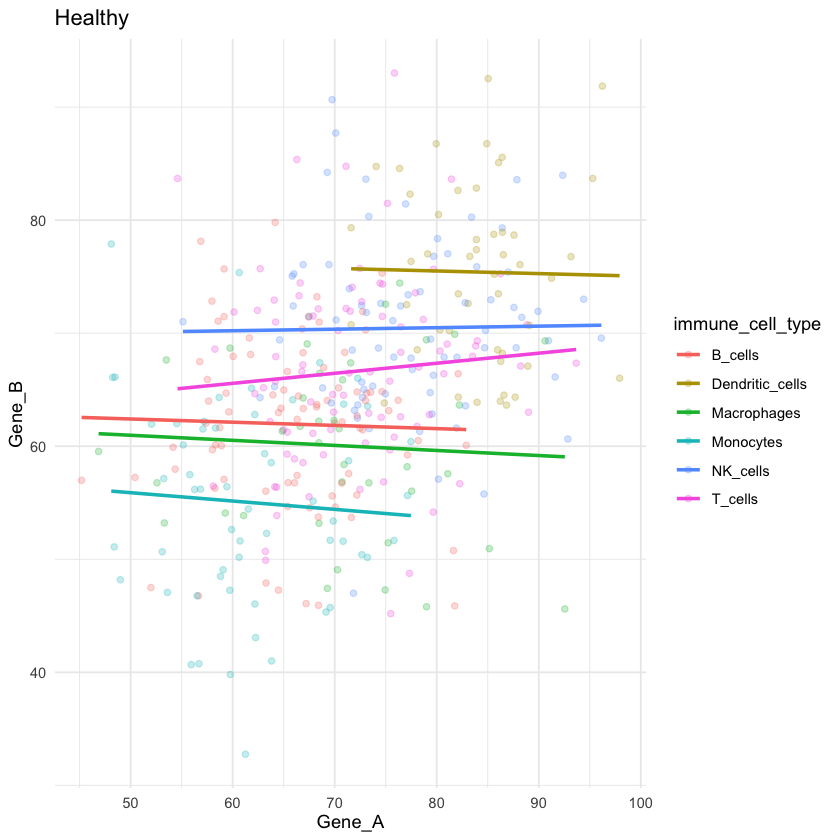

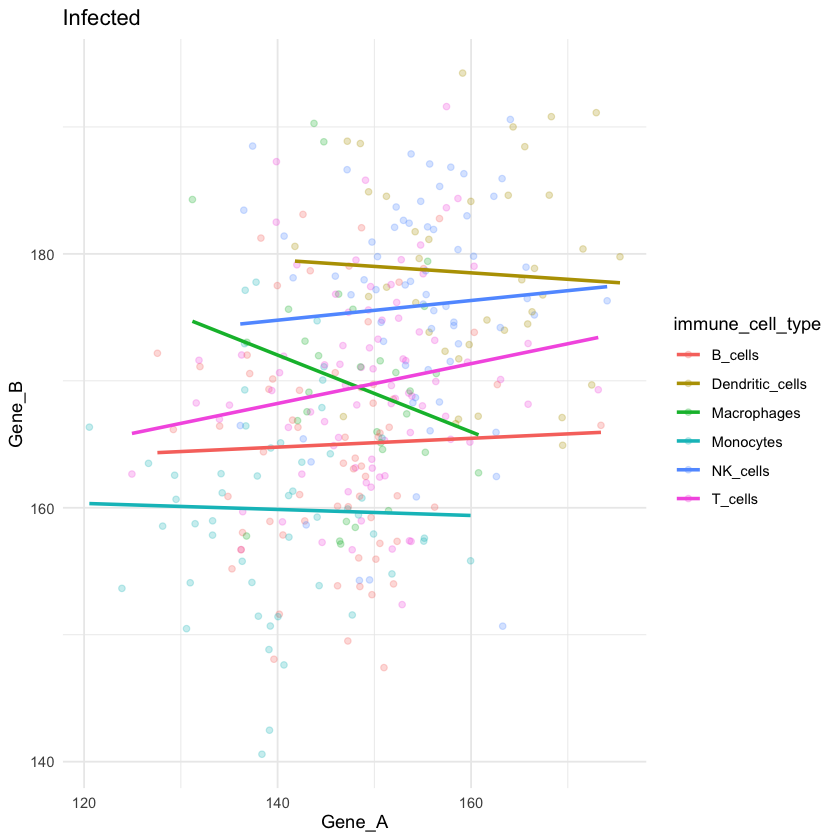

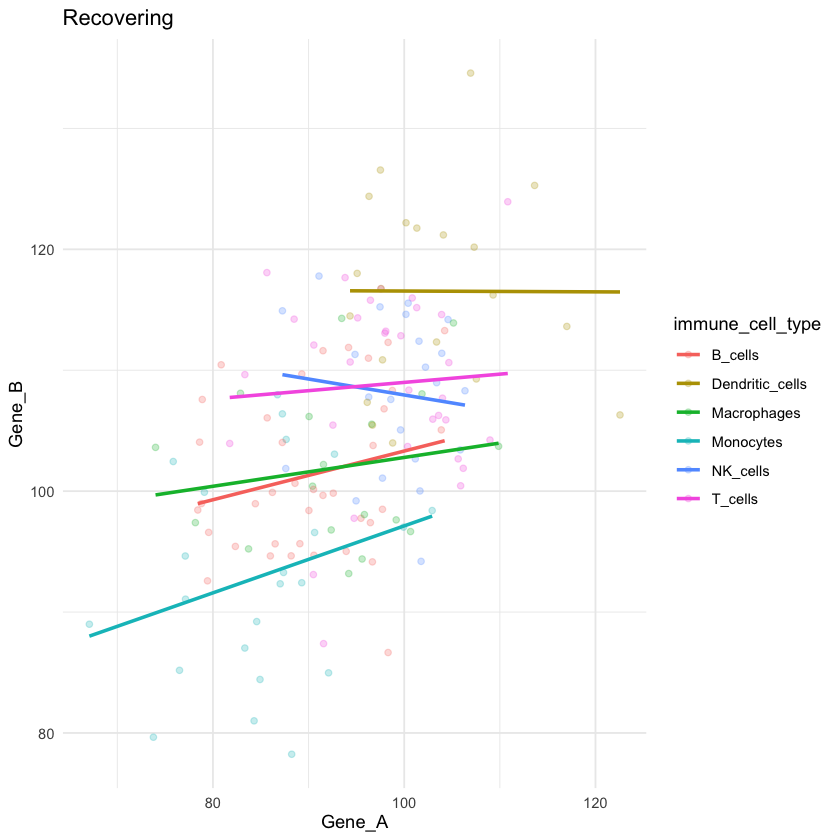

In [116]:
# does the A-B relationship change in different conditions (primarily healthy/infected/recovering) ?
ggplot(condition_data(sharks,"Healthy"), aes(x=Gene_A, y=Gene_B, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(sharks,"Infected"), aes(x=Gene_A, y=Gene_B, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Infected")

ggplot(condition_data(sharks,"Recovering"), aes(x=Gene_A, y=Gene_B, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_boxplot(fill=NA) +
    theme_minimal() +
    ggtitle("Recovering")

ggplot(condition_data(sharks,"Healthy"), aes(x=Gene_A, y=Gene_B, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Healthy")

ggplot(condition_data(sharks,"Infected"), aes(x=Gene_A, y=Gene_B, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Infected")

ggplot(condition_data(sharks,"Recovering"), aes(x=Gene_A, y=Gene_B, col=immune_cell_type)) +
    geom_point(alpha=0.25) +
    geom_smooth(aes(group=immune_cell_type, color=immune_cell_type), method="lm", formula="y ~ x", se=FALSE) +
    theme_minimal() +
    ggtitle("Recovering")

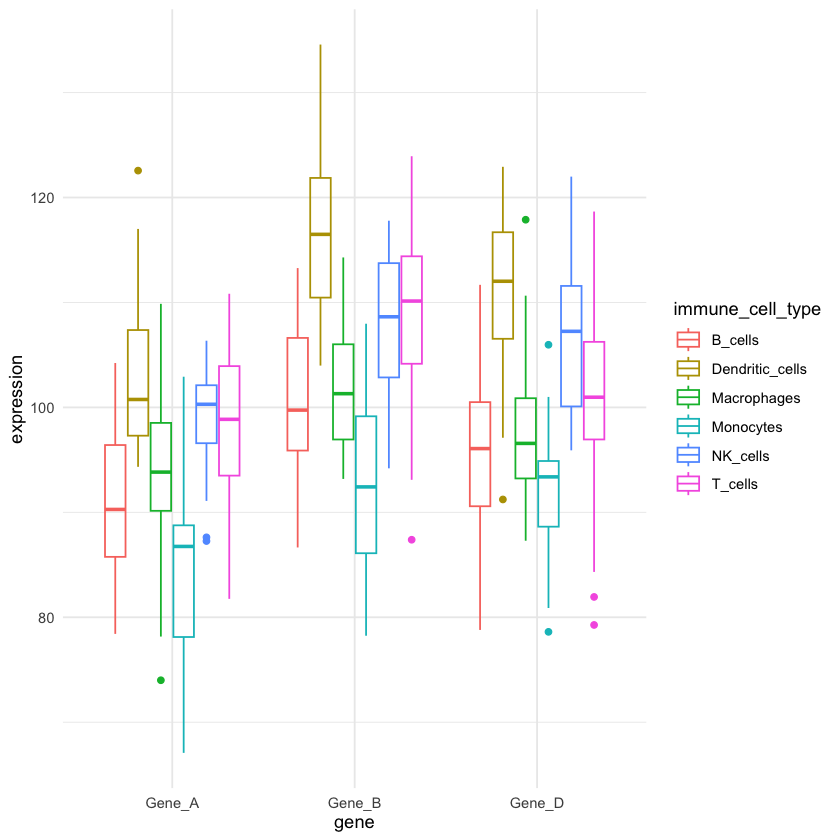

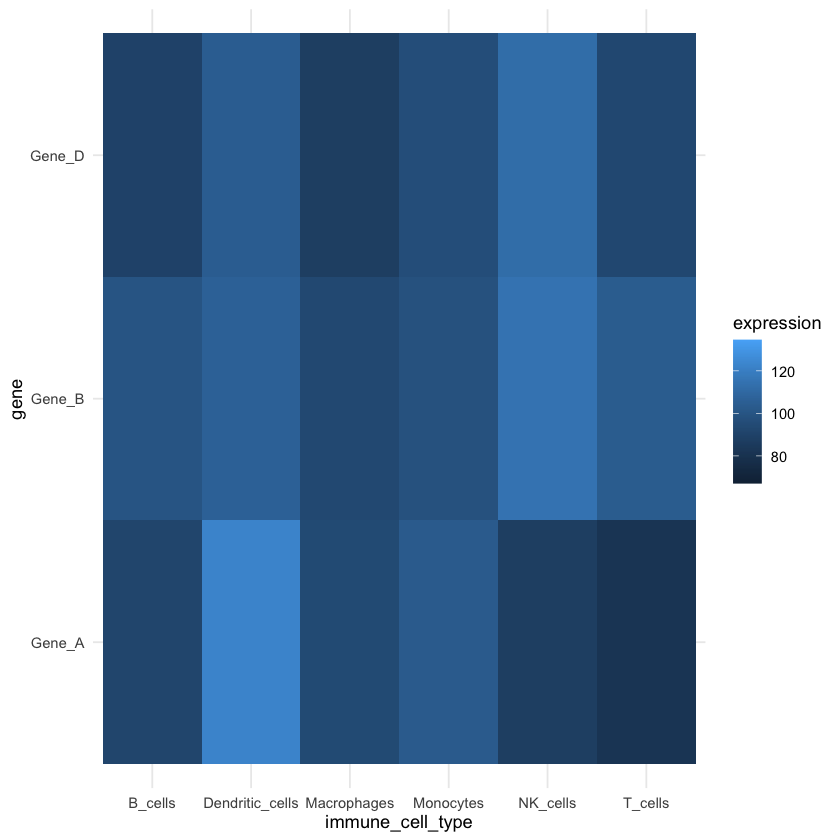

In [134]:
# are the dendritic cells mainly responsible for the expression of genes A, B, and D in the recovering condition?

genes_ABD = sharks_genes[sharks_genes$physiological_condition=="Recovering", ] %>% 
    filter(gene %in% c("Gene_A","Gene_B","Gene_D"))

ggplot(genes_ABD, aes(x=gene, y=expression, col=immune_cell_type)) +
    geom_boxplot(fill=NA) +
    theme_minimal()

ggplot(genes_ABD, aes(x=immune_cell_type, y=gene, fill=expression)) +
    geom_tile() +
    theme_minimal()